In [1]:
import erlab.plotting as eplt
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pypolar.mueller as mueller
import pypolar.visualization as vis
import xarray as xr
import xarray_lmfit as xlm


def intensity_curve(theta, theta0, s0, s1, s2, s3):
    """Calculate the intensity curve based on the given parameters.

    Parameters
    ----------
    theta
        The angle in degrees.
    theta0
        The angle offset in degrees.
    s0
        Parameter for the first sine term.
    s1
        Parameter for the second sine term.
    s2
        Parameter for the third sine term.
    s3
        Parameter for the fourth sine term.
    """
    twotheta_rad = 2 * np.deg2rad(theta - theta0)
    return 0.5 * (
        s0
        + s1 * np.cos(twotheta_rad) ** 2
        + s2 * np.cos(twotheta_rad) * np.sin(twotheta_rad)
        + s3 * np.sin(twotheta_rad)
    )


class PolarimeterModel(lmfit.Model):
    def __init__(self, **kwargs):
        super().__init__(intensity_curve, **kwargs)
        self.set_param_hint("theta0", value=0.0, vary=False)
        self.set_param_hint("s0", value=1.0, vary=True)
        self.set_param_hint("s1", value=1.0, vary=True)
        self.set_param_hint("s2", value=1.0, vary=True)
        self.set_param_hint("s3", value=1.0, vary=True)


np.set_printoptions(suppress=True)  # print 1e-16 as zero


def dolp(S):
    """Return the degree of polarization."""
    return np.sqrt(S[1] ** 2 + S[2] ** 2) / S[0]


def docp(S):
    """Return the degree of circular polarization (+1 for R, -1 for L)."""
    return S[3] / S[0]


def summarize_stokes(pol, prefix=""):
    print(prefix)
    print("Stokes Parameters\t\t:", pol)
    print("Degree of Polarization\t\t:", mueller.degree_of_polarization(pol))
    print("Degree of Linear Polarization\t:", dolp(pol))
    print("Degree of Circular Polarization\t:", docp(pol))
    print("Orientation of Ellipse\t\t:", np.rad2deg(mueller.ellipse_orientation(pol)))
    print(
        "Ellipticity Angle of Ellipse\t:", np.rad2deg(mueller.ellipse_ellipticity(pol))
    )


def make_ellipse(jones):
    t = np.linspace(0, 2 * np.pi, 100)
    x = np.real(jones[0] * np.exp(1j * t))
    y = np.real(jones[1] * np.exp(1j * t))
    return x, y


def plot_stokes(pol, **kwargs):
    plt.plot(*make_ellipse(mueller.stokes_to_jones(pol)), **kwargs)
    plt.gca().set(aspect="equal", xlim=(-1, 1), ylim=(-1, 1))

In [2]:
def load(file_name):
    arr = np.loadtxt(f"D:/Logs/Misc/{file_name}.csv", delimiter=",")
    if arr.shape[1] == 2:
        return xr.DataArray(arr[:, 1], coords=dict(ang=arr[:, 0]))
    return xr.DataArray(
        arr[:, 2],
        dims=["qwp"],
        coords=dict(hwp=("qwp", arr[:, 0]), qwp=("qwp", arr[:, 1])),
    )


plt.style.use(["khan", "nature"])

In [3]:
only_hwp = load("250728_only_hwp_try2")
only_hwp = only_hwp / only_hwp.max()

## Data with only QWP (for correction)

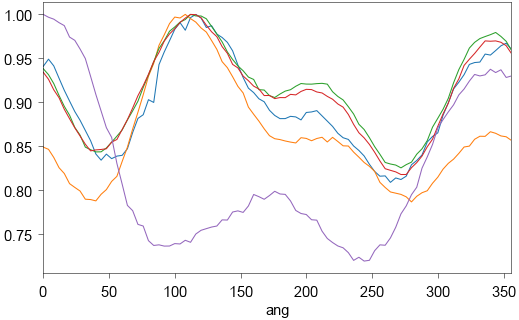

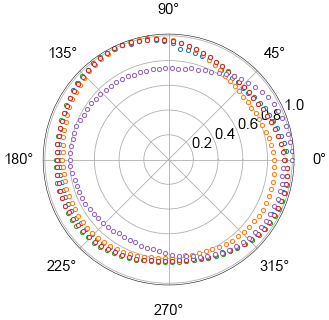

In [273]:
oq1 = load("250729_glb_qwp")
(oq1 / oq1.max()).plot()

# oq2=load("250729_glb_qwp_try2")
# (oq2/oq2.max()).plot()

# oq3=load("250729_glb_qwp_try3")
# (oq3/oq3.max()).plot()

# oq4=load("250729_glb_qwp_try4")
# (oq4/oq4.max()).plot()

oq5 = load("250729_glb_qwp_try5")
(oq5 / oq5.max()).plot()

oq6 = load("250729_only_qwp")
(oq6 / oq6.max()).plot()

oq7 = load("250729_only_qwp_try2")
(oq7 / oq7.max()).plot()

oq8 = load("250730_only_qwp")
(oq8 / oq8.max()).plot()

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.plot(np.deg2rad(oq1.ang), oq1 / oq1.max(), ".")
# ax.plot(np.deg2rad(oq2.ang), oq2/oq2.max(), '.')
# ax.plot(np.deg2rad(oq3.ang), oq3/oq3.max(), '.')
# ax.plot(np.deg2rad(oq4.ang), oq4/oq4.max(), '.')
ax.plot(np.deg2rad(oq5.ang), oq5 / oq5.max(), ".")
ax.plot(np.deg2rad(oq6.ang), oq6 / oq6.max(), ".")
ax.plot(np.deg2rad(oq7.ang), oq7 / oq7.max(), ".")
ax.plot(np.deg2rad(oq8.ang), oq8 / oq8.max(), ".")

## Dependence on HWP angle

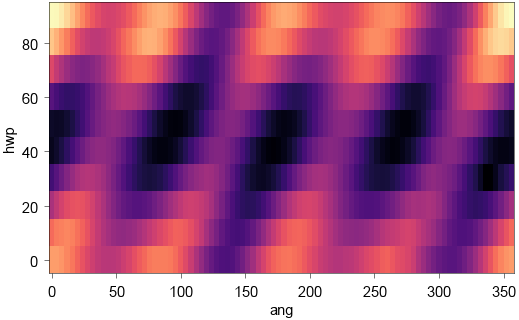

In [ ]:
hwp = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

dat = [load(f"250729_hwp{ang}_qwp_rpm") for ang in hwp]
dat = xr.concat(dat, "hwp").assign_coords(hwp=hwp)
dat.qplot(cmap="magma")

only_qwp = oq6 + oq7
only_qwp = only_qwp / only_qwp.max()

corrected = dat / only_qwp
corrected = corrected / corrected.max()

c:\Users\Scienta Omicron\Source\1KARPES_DAQ\.venv\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


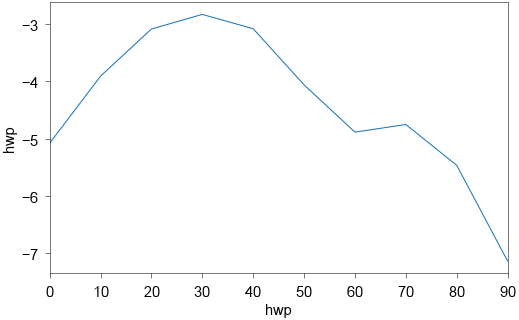

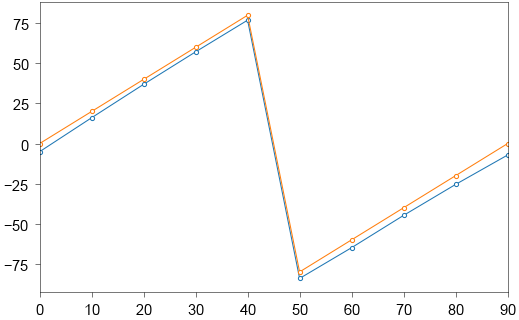

In [ ]:
# dat = load("250729_hwp0_qwp_rpm")
# dat = load("250729_hwp10_qwp_rpm")
# dat = load("250729_glb_hwp_qwp_rpm_onlyqwp")
# dat = load("250729_qwp_rpm")


# (dat/dat.max()).plot()
# plt.show()
# corrected.plot()

corrected = corrected.assign_coords(ang=corrected.ang + 0)
ds = corrected.xlm.modelfit("ang", model=PolarimeterModel(), method="leastsq")
pol = ds.modelfit_coefficients.sel(param=[f"s{i}" for i in range(4)])

(
    np.array([np.rad2deg(mueller.ellipse_orientation(np.array(p))) for p in pol])
    - ((2 * pol.hwp - 90) % 180 - 90)
).plot()

plt.show()
plt.plot(
    pol.hwp, [np.rad2deg(mueller.ellipse_orientation(np.array(p))) for p in pol], ".-"
)
plt.plot(pol.hwp, (2 * pol.hwp - 90) % 180 - 90, ".-")

c:\Users\Scienta Omicron\Source\1KARPES_DAQ\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
c:\Users\Scienta Omicron\Source\1KARPES_DAQ\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


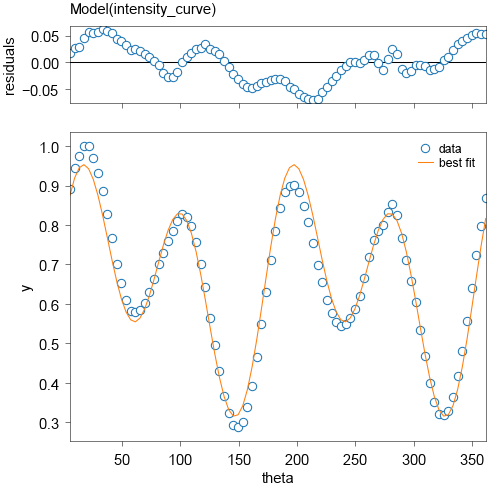

In [134]:
_ = fit_res.plot()

In [224]:
mueller.stokes_to_jones(pol[0].values)

array([ 0.84228559+0.j        , -0.07223518+0.15901375j])

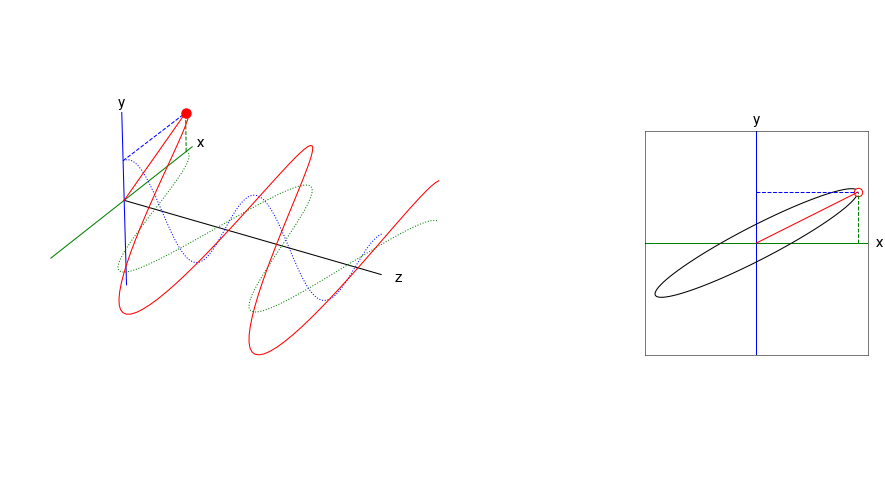

In [136]:
vis.draw_stokes_field(pol)

## Full setup, polarizer before & after mirror


Stokes Parameters		: [ 0.83671497  0.77407502 -0.32117144  0.02640662]
Degree of Polarization		: 1.0021036612779188
Degree of Linear Polarization	: 1.0016065706882773
Degree of Circular Polarization	: 0.031559871683494105
Orientation of Ellipse		: -11.26702460670879
Ellipticity Angle of Ellipse	: 0.9042738804115008

Stokes Parameters		: [ 0.9094388   0.85469441 -0.34323653  0.03703634]
Degree of Polarization		: 1.0135744069390284
Degree of Linear Polarization	: 1.012755944088237
Degree of Circular Polarization	: 0.04072439214705043
Orientation of Ellipse		: -10.939944705723063
Ellipticity Angle of Ellipse	: 1.166990619348406


c:\Users\Scienta Omicron\Source\1KARPES_DAQ\.venv\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
c:\Users\Scienta Omicron\Source\1KARPES_DAQ\.venv\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


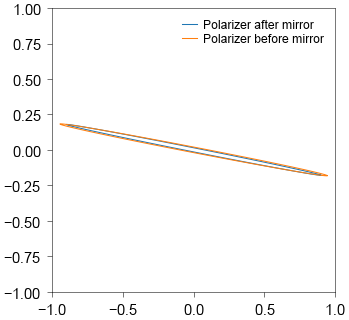

In [285]:
dat = load("250730_glb_hwp90_qwp_rpm")
only_qwp = oq8
only_qwp = only_qwp / only_qwp.max()

corrected = dat / only_qwp
corrected = corrected / corrected.max()
corrected = corrected.assign_coords(ang=corrected.ang + 0)
ds = corrected.xlm.modelfit("ang", model=PolarimeterModel(), method="leastsq")
pol_after = ds.modelfit_coefficients.sel(param=[f"s{i}" for i in range(4)])
pol_after = pol_after.values

dat = load("250730_glb_mirror_hwp90_qwp_rpm")
corrected = dat / only_qwp
corrected = corrected / corrected.max()
corrected = corrected.assign_coords(ang=corrected.ang + 0)
ds = corrected.xlm.modelfit("ang", model=PolarimeterModel(), method="leastsq")
pol_before = ds.modelfit_coefficients.sel(param=[f"s{i}" for i in range(4)])
pol_before = pol_before.values

summarize_stokes(pol_after)
summarize_stokes(pol_before)
plot_stokes(pol_after, label="Polarizer after mirror")
plot_stokes(pol_before, label="Polarizer before mirror")
plt.legend()

c:\Users\Scienta Omicron\Source\1KARPES_DAQ\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
c:\Users\Scienta Omicron\Source\1KARPES_DAQ\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


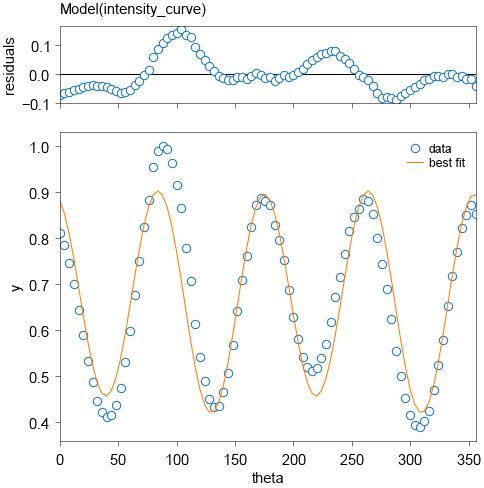

In [286]:
for r in np.atleast_1d(ds.modelfit_results).flat:
    r.plot()

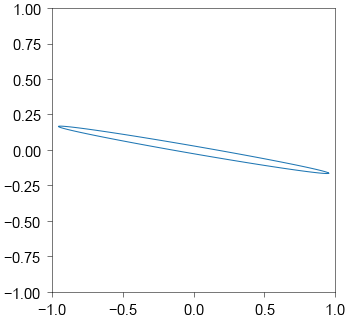

In [240]:
fig, ax = plt.subplots()
plot_stokes(pol)
ax.set(xlim=(-1, 1), ylim=(-1, 1))
ax.set_aspect("equal")

## HWP angle re-calibration

HWP offset was set to -5.7, but it looks wrong. 



Assuming laser output is aligned along LH, first remove HWP and rotate the QWP to find offset for QWP fast axis. Then, add the HWP and repeat to find HWP angle with zero retardation.

In [284]:
corrected.ang + 5.7

<xarray.DataArray 'ang' (ang: 90)> Size: 720B
array([ 11.4,  15.4,  19.4,  23.4,  27.4,  31.4,  35.4,  39.4,  43.4,
        47.4,  51.4,  55.4,  59.4,  63.4,  67.4,  71.4,  75.4,  79.4,
        83.4,  87.4,  91.4,  95.4,  99.4, 103.4, 107.4, 111.4, 115.4,
       119.4, 123.4, 127.4, 131.4, 135.4, 139.4, 143.4, 147.4, 151.4,
       155.4, 159.4, 163.4, 167.4, 171.4, 175.4, 179.4, 183.4, 187.4,
       191.4, 195.4, 199.4, 203.4, 207.4, 211.4, 215.4, 219.4, 223.4,
       227.4, 231.4, 235.4, 239.4, 243.4, 247.4, 251.4, 255.4, 259.4,
       263.4, 267.4, 271.4, 275.4, 279.4, 283.4, 287.4, 291.4, 295.4,
       299.4, 303.4, 307.4, 311.4, 315.4, 319.4, 323.4, 327.4, 331.4,
       335.4, 339.4, 343.4, 347.4, 351.4, 355.4, 359.4, 363.4, 367.4])
Coordinates:
  * ang      (ang) float64 720B 5.7 9.7 13.7 17.7 ... 349.7 353.7 357.7 361.7

c:\Users\Scienta Omicron\Source\1KARPES_DAQ\.venv\Lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")



Stokes Parameters		: [ 0.96638469  0.92133016 -0.21868015 -0.01028952]
Degree of Polarization		: 0.9799230667980035
Degree of Linear Polarization	: 0.9798652198148814
Degree of Circular Polarization	: -0.010647433490681415
Orientation of Ellipse		: -6.6761130478198965
Ellipticity Angle of Ellipse	: -0.30503226449110693


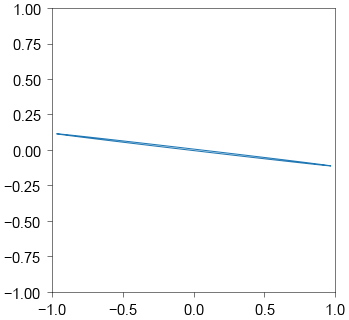

In [294]:
dat = load("250730_qwp_rpm_try2")
dat = load("250730_glb_qwp_rpm")
corrected = dat / only_qwp
corrected = corrected / corrected.max()
corrected = corrected.assign_coords(ang=corrected.ang - 0.0)
ds = corrected.xlm.modelfit("ang", model=PolarimeterModel(), method="leastsq")
pol = ds.modelfit_coefficients.sel(param=[f"s{i}" for i in range(4)])
pol = pol.values

summarize_stokes(pol)
plot_stokes(pol)

c:\Users\Scienta Omicron\Source\1KARPES_DAQ\.venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
c:\Users\Scienta Omicron\Source\1KARPES_DAQ\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


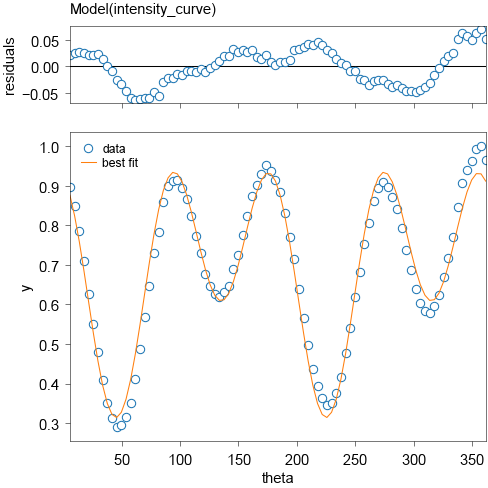

In [291]:
for r in np.atleast_1d(ds.modelfit_results).flat:
    r.plot()

## Ideal intensity curve

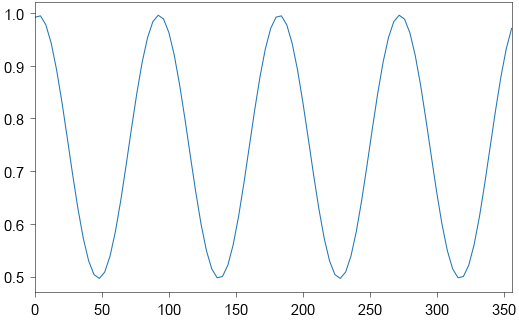

In [85]:
plt.plot(
    np.linspace(0, 356, 90),
    intensity_curve(
        np.linspace(0, 356, 90), 0.0, *mueller.stokes_linear(np.deg2rad(5))
    ),
)